# 🔵 Percobaan Baseline model SARIMA dummy data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting agar grafik terlihat lebih bagus
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8) # Membuat ukuran default grafik lebih besar

## 🗓️ Dataset loading

In [2]:
# Load dataset 
df = pd.read_csv('../data/synthetic_transactions.csv', parse_dates=['tanggal'])

In [3]:
# Cek 5 baris pertama
print("5 baris pertama dari dataset:")
display(df.head())

5 baris pertama dari dataset:


user_id    tanggal              keterangan         tipe     jumlah
0  andi_designer 2024-07-26        Kebutuhan Harian  Pengeluaran   -40447.0
1  andi_designer 2024-07-27        Kebutuhan Harian  Pengeluaran  -155725.0
2  andi_designer 2024-07-28        Kebutuhan Harian  Pengeluaran  -185734.0
3  andi_designer 2024-07-29  Pemasukan Proyek Utama    Pemasukan  3624170.0
4  andi_designer 2024-07-29        Kebutuhan Harian  Pengeluaran   -42106.0

In [4]:
# Cek informasi dasar (tipe data, jumlah baris, dll)
print("\nInformasi Dataset:")
df.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     1730 non-null   object        
 1   tanggal     1730 non-null   datetime64[ns]
 2   keterangan  1730 non-null   object        
 3   tipe        1730 non-null   object        
 4   jumlah      1730 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 67.7+ KB


## 🧪 Percobaan di Persona

### 🥷🏻 Persona Sari, need improvement but better then Persona ANdi

In [20]:
# Filter data hanya untuk Sari
sari_df = df[df['user_id'] == 'sari_ojol'].copy()

# Resampling harian
sari_daily_cashflow = sari_df.set_index('tanggal').resample('D')['jumlah'].sum().fillna(0)

print("Contoh data time-series harian untuk Sari:")
display(sari_daily_cashflow.head())

Contoh data time-series harian untuk Sari:


tanggal
2024-07-26     71269.0
2024-07-27     72648.0
2024-07-28    113413.0
2024-07-29     26677.0
2024-07-30    597322.0
Freq: D, Name: jumlah, dtype: float64

#### 📊 EDA Data Sari

In [25]:
# Buat kolom 'bulan' untuk agregasi
sari_df['bulan'] = sari_df['tanggal'].dt.to_period('M')

# Agregasi pemasukan dan pengeluaran per bulan
sari_monthly_summary = sari_df.groupby('bulan')['jumlah'].agg(
    pemasukan=lambda x: x[x > 0].sum(),
    pengeluaran=lambda x: x[x < 0].sum()
).reset_index()

sari_monthly_summary['bulan'] = sari_monthly_summary['bulan'].dt.to_timestamp()

print("Ringkasan Bulanan untuk Sari:")
display(sari_monthly_summary.head())

Ringkasan Bulanan untuk Sari:


bulan  pemasukan  pengeluaran
0 2024-07-01  1247959.0    -349678.0
1 2024-08-01  6196645.0   -2884032.0
2 2024-09-01  5882723.0   -2859918.0
3 2024-10-01  6428032.0   -2837752.0
4 2024-11-01  5876781.0   -2849125.0

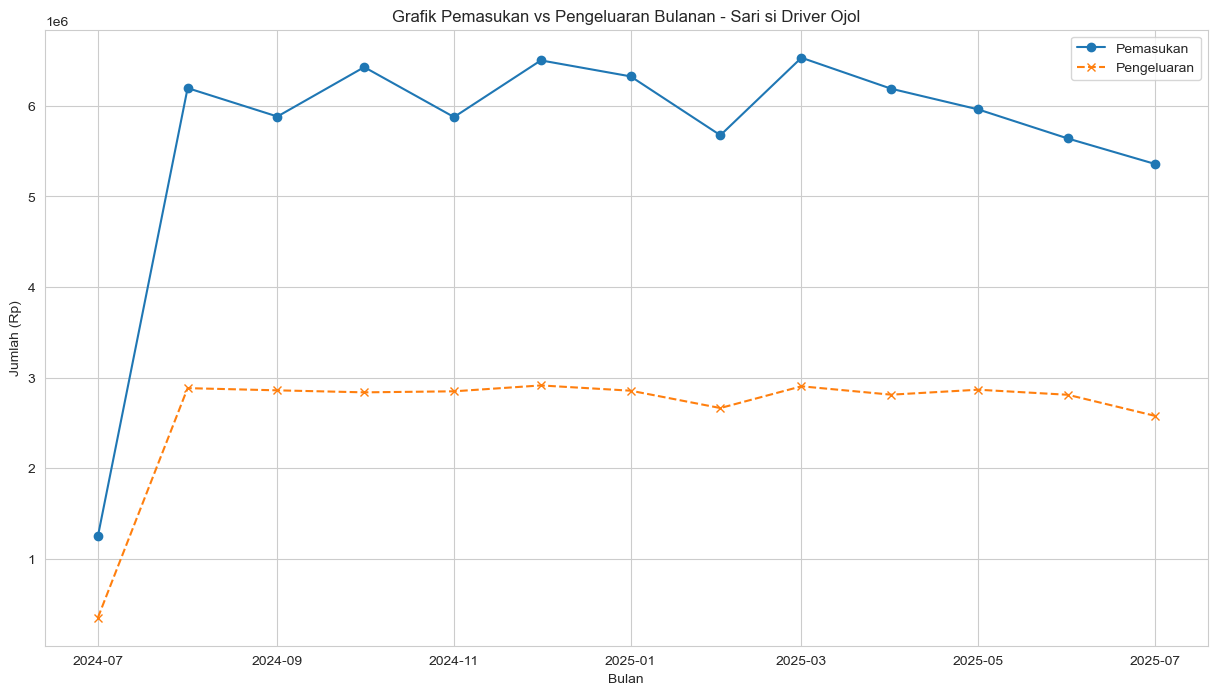

In [26]:
# Plot Pemasukan vs Pengeluaran Bulanan Sari
plt.figure()
plt.plot(sari_monthly_summary['bulan'], sari_monthly_summary['pemasukan'], marker='o', linestyle='-', label='Pemasukan')
plt.plot(sari_monthly_summary['bulan'], sari_monthly_summary['pengeluaran'].abs(), marker='x', linestyle='--', label='Pengeluaran')

plt.title('Grafik Pemasukan vs Pengeluaran Bulanan - Sari si Driver Ojol')
plt.xlabel('Bulan')
plt.ylabel('Jumlah (Rp)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Resampling data transaksi Sari menjadi data time-series harian
sari_daily_cashflow = sari_df.set_index('tanggal').resample('D')['jumlah'].sum().fillna(0)

# Visualisasikan arus kas harian
plt.figure()
sari_daily_cashflow.plot()
plt.title('Grafik Arus Kas Harian (Net Cash Flow) - Sari si Driver Ojol')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah (Rp)')
plt.show()

#### 📘 Pemodelan SARIMA Data Sari

In [21]:
# Bagi data Sari menjadi data train dan test
sari_train_data = sari_daily_cashflow.iloc[:-60]
sari_test_data = sari_daily_cashflow.iloc[-60:]

print(f"Jumlah data latihan (Sari): {len(sari_train_data)} hari")
print(f"Jumlah data tes (Sari): {len(sari_test_data)} hari")

Jumlah data latihan (Sari): 306 hari
Jumlah data tes (Sari): 60 hari


In [23]:
# Membuat dan melatih model untuk data Sari
# Pakai m=7 karena datanya harian dan polanya mingguan
model_sari = sm.tsa.SARIMAX(sari_train_data,
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 7))

result_sari = model_sari.fit()

# Buat prediksi untuk periode tes
start_pred_s = sari_test_data.index.min()
end_pred_s = sari_test_data.index.max()
predictions_sari = result_sari.get_prediction(start=start_pred_s, end=end_pred_s)
sari_predicted_mean = predictions_sari.predicted_mean

#### 🔎 Evaliasi SAARIMA Sari

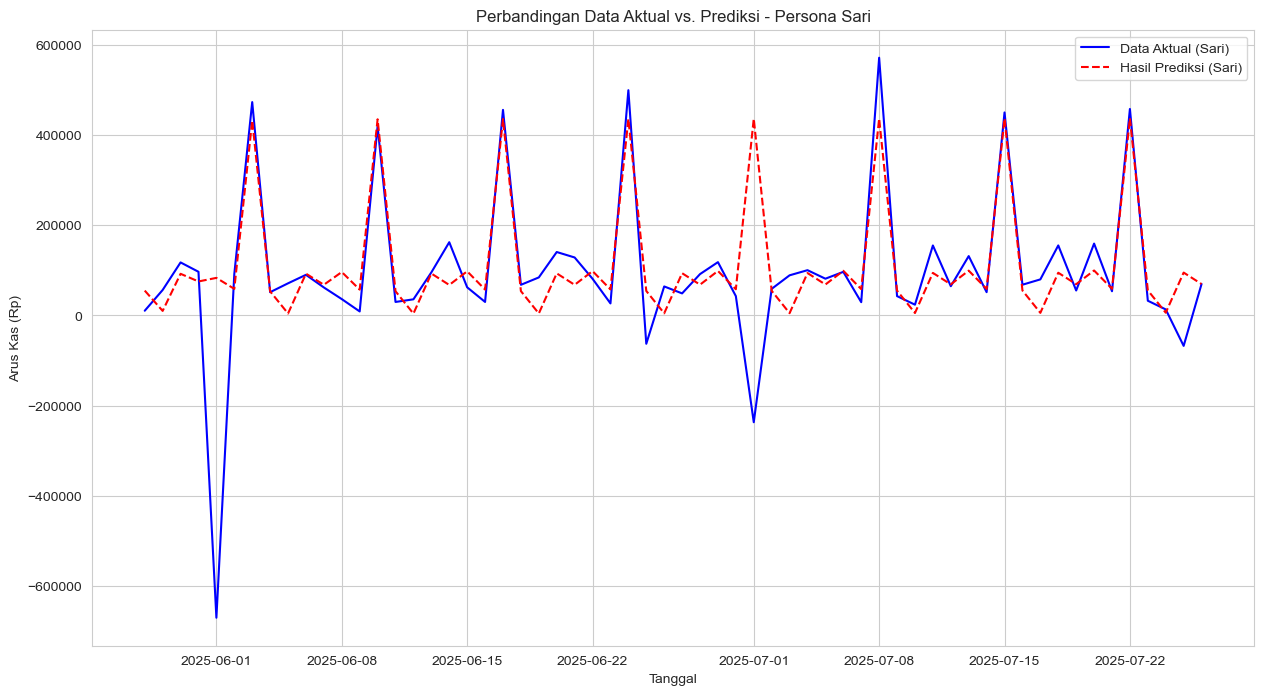

Mean Absolute Error (MAE) Sari: Rp 58,842.71
MAE Percentage Sari: 44.31%


In [24]:
# Membuat grafik perbandingan untuk data Sari
plt.figure(figsize=(15, 8))
plt.plot(sari_test_data, label='Data Aktual (Sari)', color='blue')
plt.plot(sari_predicted_mean, label='Hasil Prediksi (Sari)', color='red', linestyle='--')
plt.title('Perbandingan Data Aktual vs. Prediksi - Persona Sari')
plt.xlabel('Tanggal')
plt.ylabel('Arus Kas (Rp)')
plt.legend()
plt.show()

# Menghitung error untuk Sari
mae_sari = mean_absolute_error(sari_test_data, sari_predicted_mean)
mae_percent_sari = (mae_sari / sari_test_data.abs().mean()) * 100

print(f"Mean Absolute Error (MAE) Sari: Rp {mae_sari:,.2f}")
print(f"MAE Percentage Sari: {mae_percent_sari:.2f}%")

### 🥷🏻 Persona Andi, Deignmer Grafis (still ned improved)

#### 📊 EDA Data Andi

In [5]:
# Filter data Andi
andi_df = df[df['user_id'] == 'andi_designer'].copy()

# Buat kolom baru untuk bulan dan tahun agar mudah dianalisis
andi_df['bulan'] = andi_df['tanggal'].dt.to_period('M')

# Agregasi (kelompokkan) pemasukan dan pengeluaran per bulan
monthly_summary = andi_df.groupby('bulan')['jumlah'].agg(
    pemasukan=lambda x: x[x > 0].sum(),
    pengeluaran=lambda x: x[x < 0].sum()
).reset_index()

monthly_summary['bulan'] = monthly_summary['bulan'].dt.to_timestamp()

print("Ringkasan Bulanan untuk Andi:")
display(monthly_summary.head())

Ringkasan Bulanan untuk Andi:


bulan  pemasukan  pengeluaran
0 2024-07-01  3624170.0    -524887.0
1 2024-08-01  6483282.0   -5021837.0
2 2024-09-01  4305908.0   -5095377.0
3 2024-10-01  3720383.0   -5082284.0
4 2024-11-01  7435165.0   -5008695.0

In [6]:
# Plot Pemasukan vs Pengeluaran Bulanan Andi
plt.figure()
plt.plot(monthly_summary['bulan'], monthly_summary['pemasukan'], marker='o', linestyle='-', label='Pemasukan')
plt.plot(monthly_summary['bulan'], monthly_summary['pengeluaran'].abs(), marker='x', linestyle='--', label='Pengeluaran')

plt.title('Grafik Pemasukan vs Pengeluaran Bulanan - Andi si Desainer')
plt.xlabel('Bulan')
plt.ylabel('Jumlah (Rp)')
plt.legend()
plt.grid(True)
plt.show()

Contoh data time-series harian (arus kas bersih) untuk Andi:


tanggal
2024-07-26     -40447.0
2024-07-27    -155725.0
2024-07-28    -185734.0
2024-07-29    3582064.0
2024-07-30     -42758.0
Freq: D, Name: jumlah, dtype: float64

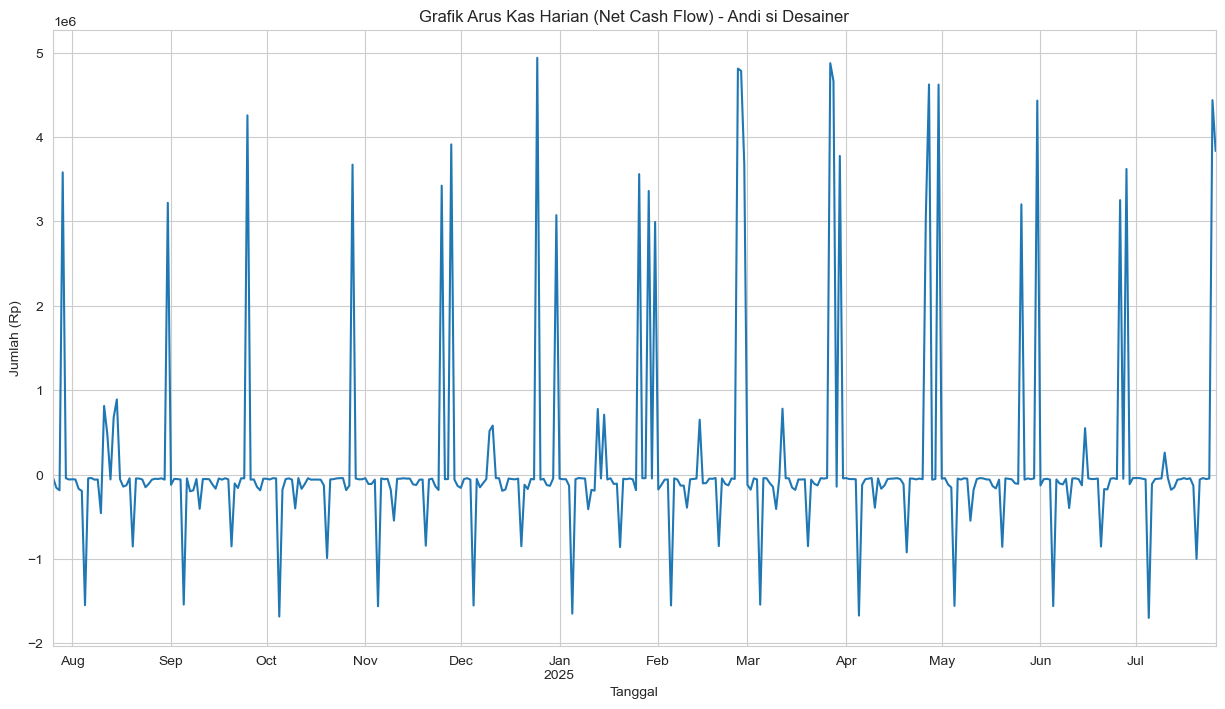

In [7]:
# Fokus pada kolom 'jumlah' (arus kas bersih)
daily_cashflow = andi_df.set_index('tanggal').resample('D')['jumlah'].sum().fillna(0)

print("Contoh data time-series harian (arus kas bersih) untuk Andi:")
display(daily_cashflow.head())

# Visualisasikan arus kas harian
plt.figure()
daily_cashflow.plot()
plt.title('Grafik Arus Kas Harian (Net Cash Flow) - Andi si Desainer')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah (Rp)')
plt.show()

#### 📘 Pemodelan SARIMA data Andi Percobaan 1 (Bad)

In [8]:
# Data ada 365 hari. Pakai ~10 bulan (305 hari) untuk melatih model,
# dan sisa ~2 bulan (60 hari) untuk menguji.

train_data = daily_cashflow.iloc[:-60]
test_data = daily_cashflow.iloc[-60:]

print(f"Jumlah data latihan (train): {len(train_data)} hari")
print(f"Jumlah data tes (test): {len(test_data)} hari")

Jumlah data latihan (train): 306 hari
Jumlah data tes (test): 60 hari


In [9]:
# Import library untuk model SARIMA
import statsmodels.api as sm

# Membuat model SARIMA
model = sm.tsa.SARIMAX(train_data,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 7))

# Melatih model dengan data. Ini adalah proses "belajar"-nya.
# Proses ini mungkin butuh beberapa detik.
result = model.fit()

# Tampilkan ringkasan hasil modelnya
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            jumlah   No. Observations:                  306
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4617.692
Date:                           Sat, 26 Jul 2025   AIC                           9245.384
Time:                                   19:37:32   BIC                           9263.870
Sample:                               07-26-2024   HQIC                          9252.784
                                    - 05-27-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1811      0.104      1.744      0.081      -0.022       0.385
ma.L1         -0.9804      0.071    -13.874

Parameter order dan seasonal_order:

Ini adalah "setelan" atau "konfigurasi" untuk mesin SARIMA kita. Angka (p,d,q) dan (P,D,Q,m) ini memberitahu model bagaimana cara belajar dari data.

Angka m=7 di seasonal_order=(1, 1, 1, 7) adalah yang paling penting. Ini memberitahu model, "Hei, aku curiga ada pola musiman setiap 7 hari di data ini."

Untuk saat ini, kita pakai angka standar (1,1,1). Menemukan angka terbaik adalah proses lanjutan yang disebut hyperparameter tuning.

In [10]:
# Tentukan dari kapan sampai kapan kita mau prediksi
start_pred = test_data.index.min()
end_pred = test_data.index.max()

# Buat prediksi
predictions = result.get_prediction(start=start_pred, end=end_pred)
predicted_mean = predictions.predicted_mean

# Tampilkan beberapa hasil prediksi pertama
print("Contoh hasil prediksi:")
display(predicted_mean.head())

Contoh hasil prediksi:


2025-05-28    617295.421653
2025-05-29    306790.769655
2025-05-30    392183.680595
2025-05-31      3779.379261
2025-06-01    421198.467440
Freq: D, Name: predicted_mean, dtype: float64

#### 🔎 Evaluasi SARIMA Andi

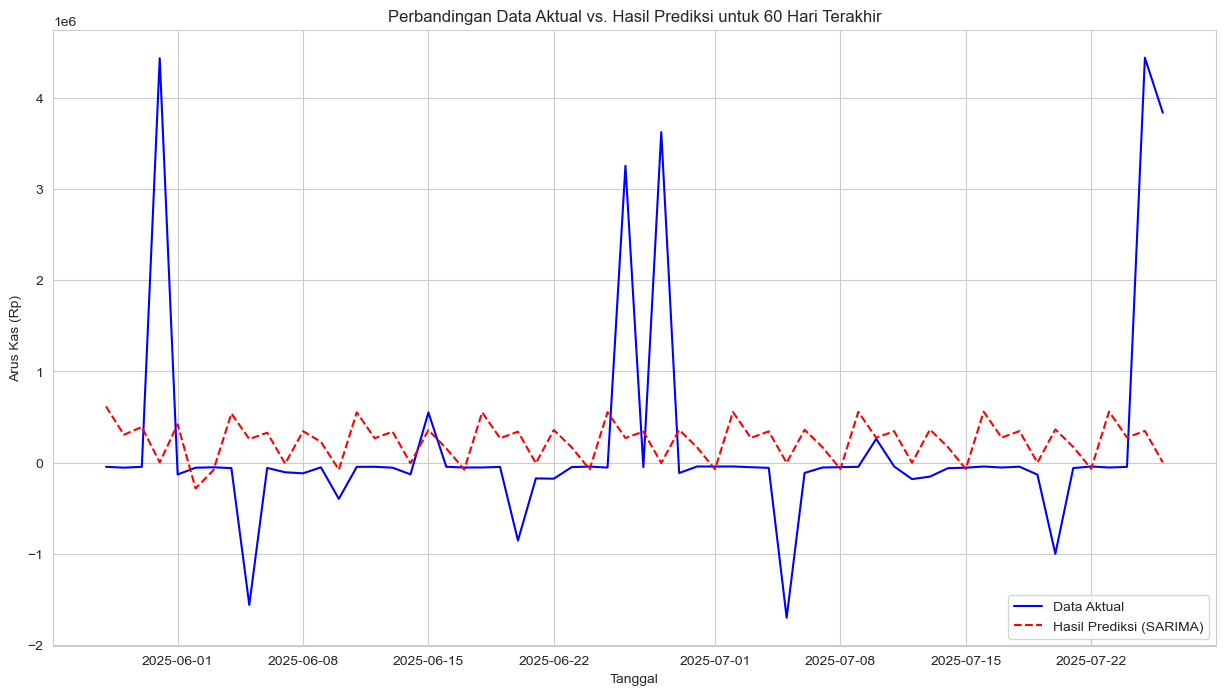

Mean Absolute Error (MAE): Rp 691,154.24
Artinya, rata-rata prediksi kita meleset sebesar angka di atas.
MAE Percentage: 141.97%


In [11]:
# Import library untuk evaluasi
from sklearn.metrics import mean_absolute_error

# Membuat grafik perbandingan
plt.figure(figsize=(15, 8))
plt.plot(test_data, label='Data Aktual', color='blue')
plt.plot(predicted_mean, label='Hasil Prediksi (SARIMA)', color='red', linestyle='--')

plt.title('Perbandingan Data Aktual vs. Hasil Prediksi untuk 60 Hari Terakhir')
plt.xlabel('Tanggal')
plt.ylabel('Arus Kas (Rp)')
plt.legend()
plt.show()

# Menghitung error
mae = mean_absolute_error(test_data, predicted_mean)
mae_percent = (mae / test_data.abs().mean()) * 100

print(f"Mean Absolute Error (MAE): Rp {mae:,.2f}")
print(f"Artinya, rata-rata prediksi kita meleset sebesar angka di atas.")
print(f"MAE Percentage: {mae_percent:.2f}%")

#### Percobaan 2 Andi

In [12]:
# Resample data harian menjadi mingguan, dengan menjumlahkan semua transaksi dalam seminggu.
# 'W' artinya Weekly. Pandas cukup pintar untuk tahu ini.
weekly_cashflow = daily_cashflow.resample('W').sum()

print("Contoh data setelah diubah menjadi mingguan:")
display(weekly_cashflow.head())

# Mari kita lihat grafiknya, seharusnya terlihat lebih 'halus'
plt.figure()
weekly_cashflow.plot()
plt.title('Grafik Arus Kas Mingguan (Net Cash Flow) - Andi si Desainer')
plt.xlabel('Minggu')
plt.ylabel('Jumlah (Rp)')
plt.show()

Contoh data setelah diubah menjadi mingguan:


tanggal
2024-07-28    -381906.0
2024-08-04    3007644.0
2024-08-11   -1390355.0
2024-08-18    1669634.0
2024-08-25   -1302421.0
Freq: W-SUN, Name: jumlah, dtype: float64

In [13]:
# Bagi data mingguan
train_weekly = weekly_cashflow.iloc[:-8]
test_weekly = weekly_cashflow.iloc[-8:]

print(f"Jumlah data latihan (train): {len(train_weekly)} minggu")
print(f"Jumlah data tes (test): {len(test_weekly)} minggu")

Jumlah data latihan (train): 45 minggu
Jumlah data tes (test): 8 minggu


In [14]:
# Membuat dan melatih model baru dengan data mingguan
# Perhatikan perubahan di seasonal_order, m=4 artinya kita mencari pola 4-mingguan (bulanan)
model_weekly = sm.tsa.SARIMAX(train_weekly,
                              order=(1, 1, 1),
                              seasonal_order=(1, 1, 1, 4)) # m=4 untuk pola bulanan

result_weekly = model_weekly.fit()

# Buat prediksi untuk periode tes
start_pred_w = test_weekly.index.min()
end_pred_w = test_weekly.index.max()
predictions_weekly = result_weekly.get_prediction(start=start_pred_w, end=end_pred_w)
predicted_mean_weekly = predictions_weekly.predicted_mean

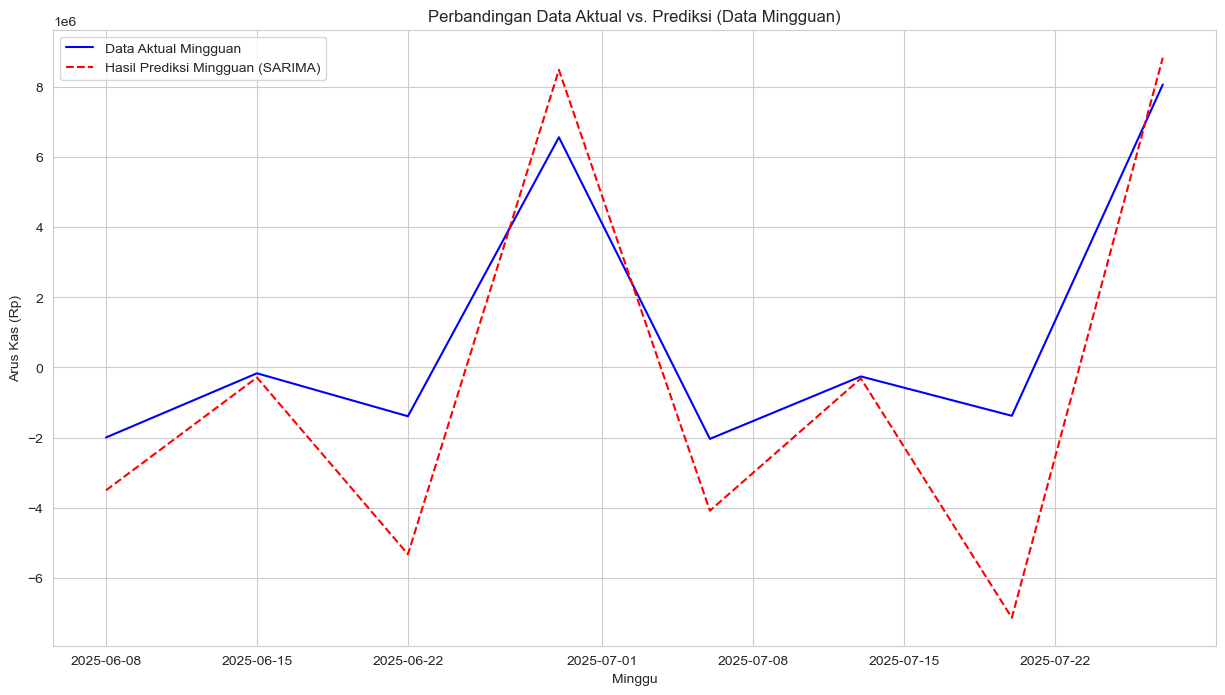

Mean Absolute Error (MAE) Mingguan: Rp 2,015,338.30
MAE Percentage Mingguan: 73.70%


In [15]:
# Membuat grafik perbandingan untuk data mingguan
plt.figure(figsize=(15, 8))
plt.plot(test_weekly, label='Data Aktual Mingguan', color='blue')
plt.plot(predicted_mean_weekly, label='Hasil Prediksi Mingguan (SARIMA)', color='red', linestyle='--')

plt.title('Perbandingan Data Aktual vs. Prediksi (Data Mingguan)')
plt.xlabel('Minggu')
plt.ylabel('Arus Kas (Rp)')
plt.legend()
plt.show()

# Menghitung error baru
mae_weekly = mean_absolute_error(test_weekly, predicted_mean_weekly)
mae_percent_weekly = (mae_weekly / test_weekly.abs().mean()) * 100

print(f"Mean Absolute Error (MAE) Mingguan: Rp {mae_weekly:,.2f}")
print(f"MAE Percentage Mingguan: {mae_percent_weekly:.2f}%")